## Sentiment Analysis

One of the most popular applications of NLP, sentiment analysis is of great significance in Data Analytics. It helps organizations study and analyse the impact and influence of thier products/services. <br>
A basic task in sentiment analysis is classifying the polarity of a given text at the document, sentence, or feature/aspect level—whether the expressed opinion in a document, a sentence or an entity feature/aspect is **positive**, **negative**, or **neutral**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

## Setup

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['font.size'] = 18

In [4]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

## Loading the Data

In [5]:
data = pd.read_csv('../input/spotify-app-reviews-2022/reviews.csv')
data.head(10)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
5,2022-07-09 13:20:20,The player controls sometimes disappear for no...,3,7,NaN
6,2022-07-09 13:19:21,I love the selection and the lyrics are provid...,5,0,NaN
7,2022-07-09 13:17:22,Still extremely slow when changing storage to ...,3,16,NaN
8,2022-07-09 13:16:49,It's a great app and the best mp3 music app I ...,5,0,NaN
9,2022-07-09 13:11:32,"I'm deleting this app, for the following reaso...",1,318,NaN


In [6]:
data.iloc[4,1]

"Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?"

In [7]:
print(f'Number of samples: {data.shape[0]}\nNumber of features: {data.shape[1]}')

Number of samples: 61594
Number of features: 5


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [9]:
data['Reply'].isna().sum()

61378

Drop Time and Reply

In [10]:
data.drop(['Time_submitted', 'Reply'], axis=1, inplace=True)

In [11]:
data.head()

,Review,Rating,Total_thumbsup
0,"Great music service, the audio is high quality...",5,2
1,Please ignore previous negative rating. This a...,5,1
2,"This pop-up ""Get the best Spotify experience o...",4,0
3,Really buggy and terrible to use as of recently,1,1
4,Dear Spotify why do I get songs that I didn't ...,1,1


## Visualization and EDA

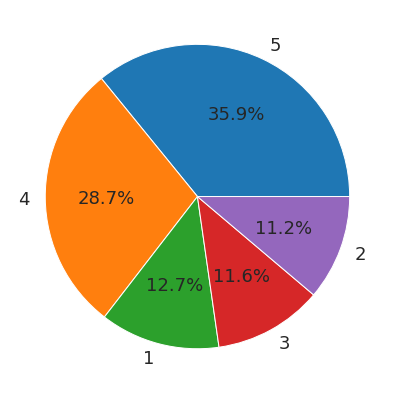

In [12]:
plt.pie(data['Rating'].value_counts(), labels=data['Rating'].unique(), autopct='%1.1f%%')
plt.show()

In [13]:
def transform_ratings(rating):
    if rating == 5 or rating == 4:
        return "Good"
    if rating == 3:
        return "Neutral"
    if rating == 2 or rating == 1:
        return "Bad"

In [14]:
data['Rating'] = data['Rating'].apply(transform_ratings)
data['length'] = data['Review'].str.len()

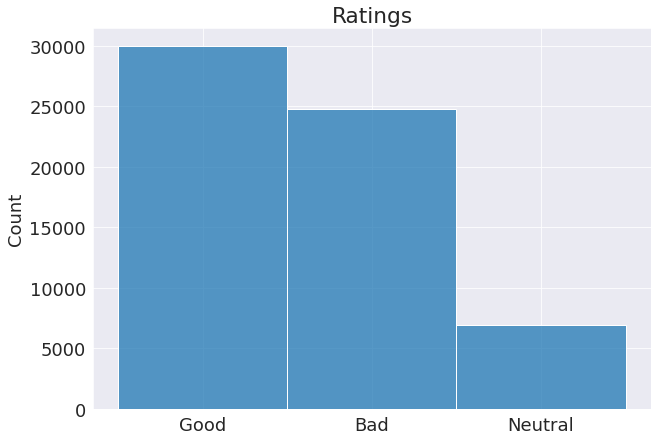

In [15]:
sns.histplot(data['Rating'])
plt.title('Ratings')
plt.xlabel('')
plt.show()

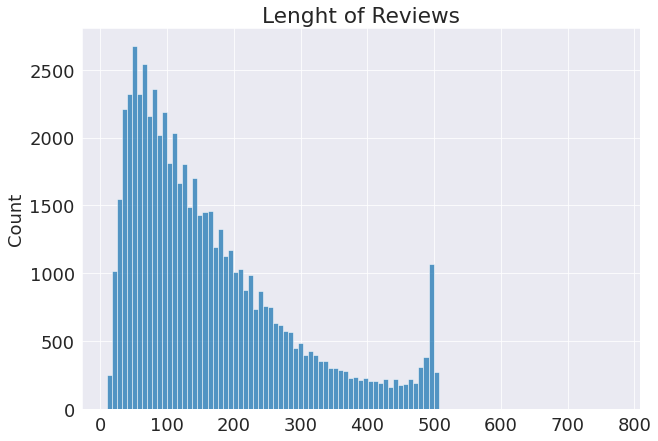

In [16]:
sns.histplot(data['length'][data.length<800])
plt.title('Lenght of Reviews')
plt.xlabel('')
plt.show()

In [17]:
data['length'].describe()

count    61594.000000
mean       163.323457
std        119.940997
min         10.000000
25%         72.000000
50%        130.000000
75%        221.000000
max       3753.000000
Name: length, dtype: float64

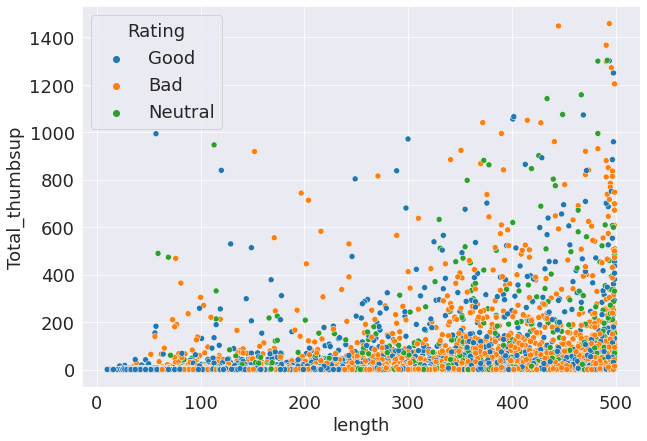

In [18]:
sns.scatterplot(x=data['length'][data.length < 500], y=data['Total_thumbsup'][data.Total_thumbsup < 1500], hue=data['Rating'])
plt.show()

## Text Preprocessing
1. Lowercase
2. Remove punctuations
3. Tokenize
4. Stopword Removal
5. Lemmatize

In [19]:
data.loc[:,'Review'] = data.loc[:,'Review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data.head(10)

,Review,Rating,Total_thumbsup,length
0,"great music service, the audio is high quality...",Good,2,112
1,please ignore previous negative rating. this a...,Good,1,86
2,"this pop-up ""get the best spotify experience o...",Good,0,106
3,really buggy and terrible to use as of recently,Bad,1,47
4,dear spotify why do i get songs that i didn't ...,Bad,1,100
5,the player controls sometimes disappear for no...,Neutral,7,114
6,i love the selection and the lyrics are provid...,Good,0,83
7,still extremely slow when changing storage to ...,Neutral,16,352
8,it's a great app and the best mp3 music app i ...,Good,0,210
9,"i'm deleting this app, for the following reaso...",Bad,318,443


In [20]:
import re
data.loc[:,'Review'] = data.loc[:,'Review'].apply(lambda word: re.sub('[^a-z A-Z 0-9-]+', '', word))
data.head(10)

,Review,Rating,Total_thumbsup,length
0,great music service the audio is high quality ...,Good,2,112
1,please ignore previous negative rating this ap...,Good,1,86
2,this pop-up get the best spotify experience on...,Good,0,106
3,really buggy and terrible to use as of recently,Bad,1,47
4,dear spotify why do i get songs that i didnt p...,Bad,1,100
5,the player controls sometimes disappear for no...,Neutral,7,114
6,i love the selection and the lyrics are provid...,Good,0,83
7,still extremely slow when changing storage to ...,Neutral,16,352
8,its a great app and the best mp3 music app i h...,Good,0,210
9,im deleting this app for the following reasons...,Bad,318,443


In [21]:
stop_words = stopwords.words('english')
data.loc[:,'Review'] = data.loc[:,'Review'].apply(lambda word: " ".join(word for word in word.split() if word not in stop_words))
data.head(10)

,Review,Rating,Total_thumbsup,length
0,great music service audio high quality app eas...,Good,2,112
1,please ignore previous negative rating app sup...,Good,1,86
2,pop-up get best spotify experience android 12 ...,Good,0,106
3,really buggy terrible use recently,Bad,1,47
4,dear spotify get songs didnt put playlist shuf...,Bad,1,100
5,player controls sometimes disappear reason app...,Neutral,7,114
6,love selection lyrics provided song youre list...,Good,0,83
7,still extremely slow changing storage external...,Neutral,16,352
8,great app best mp3 music app ever used one pro...,Good,0,210
9,im deleting app following reasons app failing ...,Bad,318,443


In [22]:
lemmat = WordNetLemmatizer()
data.loc[:,'Review'] = data.loc[:,'Review'].apply(lambda word: " ".join(lemmat.lemmatize(word) for word in word.split()))
data.head(10)

,Review,Rating,Total_thumbsup,length
0,great music service audio high quality app eas...,Good,2,112
1,please ignore previous negative rating app sup...,Good,1,86
2,pop-up get best spotify experience android 12 ...,Good,0,106
3,really buggy terrible use recently,Bad,1,47
4,dear spotify get song didnt put playlist shuff...,Bad,1,100
5,player control sometimes disappear reason app ...,Neutral,7,114
6,love selection lyric provided song youre liste...,Good,0,83
7,still extremely slow changing storage external...,Neutral,16,352
8,great app best mp3 music app ever used one pro...,Good,0,210
9,im deleting app following reason app failing b...,Bad,318,443


## Feature Engineering

* Splitting into Train and Test sets
* Label Encoding
* Text Encoding
> 1. Count Vectorization
> 2. TF-IDF Character Level

### Splitting the data

In [23]:
X = data['Review']
y = data['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((46195,), (15399,), (46195,), (15399,))

### Label Encoding

In [24]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

### Count Vectorization

In [25]:
cv = CountVectorizer()
cv.fit(X_train)
X_train_count = cv.transform(X_train)
X_test_count = cv.transform(X_test)

In [26]:
cv.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '0000000001',
 '0001',
 '0003',
 '000348',
 '0009',
 '001',
 '004']

### Character Level TF-IDF

In [27]:
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2,3))
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [28]:
tfidf.get_feature_names()[:10]

[' -', ' - ', ' --', ' -0', ' -1', ' -2', ' -3', ' -4', ' -5', ' -6']

## Classification

### Random Forest - Count Vectors

In [29]:
rf1 = RandomForestClassifier()
rf1.fit(X_train_count, y_train)
rf_cv = rf1.score(X_test_count, y_test)
print(f'Random Forest Classifier on Count Vectors: {rf_cv}')

Random Forest Classifier on Count Vectors: 0.7772582635236054


### Random Forest - TF-IDF

In [30]:
rf2 = RandomForestClassifier()
rf2.fit(X_train_tfidf, y_train)
rf_tfidf = rf2.score(X_test_tfidf, y_test)
print(f'Random Forest Classifier on TF-IDF Vectors: {rf_tfidf}')

Random Forest Classifier on TF-IDF Vectors: 0.7519319436327034


### MultinomialNB - Count Vectors

In [31]:
mnb1 = MultinomialNB()
mnb1.fit(X_train_count, y_train)
mnb_cv = mnb1.score(X_test_count, y_test)
print(f'Multinomial Naive Bayes Classifier on Count Vectors: {mnb_cv}')

Multinomial Naive Bayes Classifier on Count Vectors: 0.7755049029157738


### MultinomialNB - TF-IDF

In [32]:
mnb2 = MultinomialNB()
mnb2.fit(X_train_tfidf, y_train)
mnb_tfidf = mnb2.score(X_test_tfidf, y_test)
print(f'Multinomial Naive Bayes Classifier on TF-IDF Vectors: {mnb_tfidf}')

Multinomial Naive Bayes Classifier on TF-IDF Vectors: 0.7555685434119098


## Model Results

In [33]:
model = {'Model':['RandomForestClassifier-CountVectors', 
                  'RandomForestClassifier-TFIDFVectors', 
                  'MultinomialNBClassifier-CountVectors',
                  'MultinomialNBClassifier-TFIDFVectors'],
         'Score':[rf_cv, rf_tfidf, mnb_cv, mnb_tfidf]
         }
model_df = pd.DataFrame(model)
model_df

,Model,Score
0,RandomForestClassifier-CountVectors,0.777258
1,RandomForestClassifier-TFIDFVectors,0.751932
2,MultinomialNBClassifier-CountVectors,0.775505
3,MultinomialNBClassifier-TFIDFVectors,0.755569


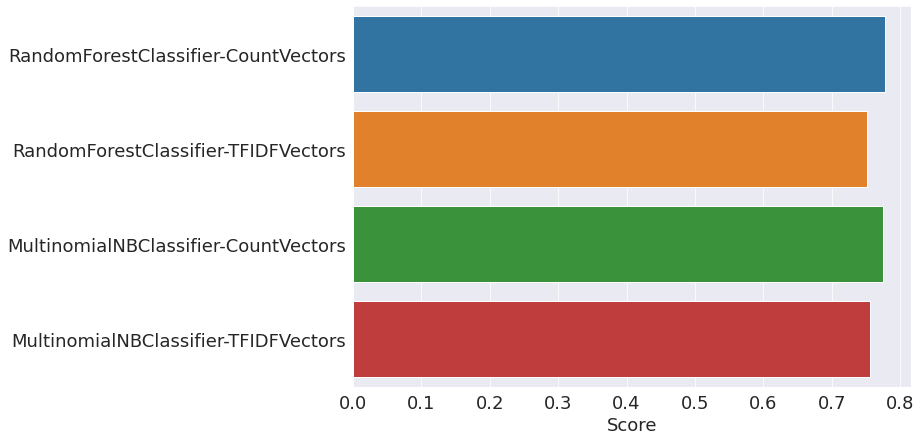

In [34]:
sns.barplot(data=model_df, y='Model', x='Score')
plt.ylabel('')
plt.show()

## Prediction

In [35]:
test_reviews = ['This is a great app!', 'Uncomfortable UI, always lagging', 'I like the song selection, but the ads are annoying']
pred = mnb1.predict(cv.transform(test_reviews))
pred_transformed = le.inverse_transform(pred).tolist()

In [36]:
result = pd.DataFrame({'Reviews':test_reviews, 
                       'Outcome': pred_transformed})
result

,Reviews,Outcome
0,This is a great app!,Good
1,"Uncomfortable UI, always lagging",Bad
2,"I like the song selection, but the ads are ann...",Neutral
